In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def data_generator(H, n, w_star, sigma=1):
    d = H.shape[0]
    
    X = np.random.randn(n, d).dot(H**0.5)
    Y = X.dot(w_star) + sigma*np.random.randn(n,1)
    
    return X, Y

In [3]:
d = 200
n = 5000
# target covariance
eigs = np.array([1/(t+1)**1.5 for t in range(d)])
H = np.diag(eigs)

# source covariance
eigs = np.array([1/(t+1)**2 for t in range(d)])
k = 20
# reverse the eigenvalues
eigs2 = np.copy(eigs[:k])
eigs[:k] = eigs2[::-1]

G = np.diag(eigs)
# ground truth
w_star = [.5 if t<k else 1/(t+1) for t in range(d) ]
w_star = np.array(w_star)
w_star = w_star[:, np.newaxis]





In [4]:
def train(gamma1, gamma2, M, N, n=50000):
    
    X_source, Y_source = data_generator(G, n, w_star)
    X_target, Y_target = data_generator(H, n, w_star)
    
    
    w = np.zeros([d, 1])
    
    X_s, Y_s = X_source[:M, :], Y_source[:M, :]
    X_t, Y_t = X_target[:N, :], Y_target[:N, :]
    
    L1 = np.ceil(M / np.log2(M)) if M > 0 else M
    L2 = np.ceil(N / np.log2(N)) if N > 0 else M
    
    loss_log = [np.sum(np.dot(np.dot(w.T - w_star.T, H), w - w_star))]
    # pretraining
    eta = gamma1
    for i in range(M):
        x = X_s[[i], :]
        y = Y_s[[i], :]
        grad = np.dot(np.dot(x.T, x), w) - np.dot(x.T, y)
        if (i+1) % L1 == 0:
            eta /= 2
        
        w -= eta * grad
        
        loss_log += [np.sum(np.dot(np.dot(w.T - w_star.T, H), w - w_star))]
    # finetuning
    eta = gamma2
    for i in range(N):
        x = X_t[[i], :]
        y = Y_t[[i], :]
        grad = np.dot(np.dot(x.T, x), w) - np.dot(x.T, y)

        if (i+1) % L2 == 0:
            eta /= 2
        
        w -= eta * grad
        
        loss_log += [np.sum(np.dot(np.dot(w.T - w_star.T, H), w - w_star))]
    return np.array(loss_log)


In [5]:
loss_pretrain1 = []
loss_supervise1 = []
loss_finetune1 = []
Ms = [0, 100, 500, 1000,  2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000]
Ns = [0, 20, 50, 100, 300, 500, 750, 1000,  2000, 3000, 5000]
repeat = 10


for M in Ms:
    loss_pretrain_res = 0
    for _ in range(repeat*3):
        loss = train(gamma1=0.1, gamma2=0.1, M=M, N=0)[-1]
        loss_pretrain_res += loss / repeat / 3
        
    loss_pretrain1 += [loss_pretrain_res]
    
    print ("pretrain, M={}".format(M))
    
for N in Ns:
    loss_supervise_res = 0
    loss_finetune_res = 0
    for _ in range(repeat):
        loss = train(gamma1=0.1, gamma2=0.1, M=0, N=N)[-1]
        loss_supervise_res += loss / repeat
        
        loss = train(gamma1=0.1, gamma2=0.02, M=5000, N=N)[-1]
        loss_finetune_res += loss / repeat
        
    print ("supervise and finetune, N={}".format(N))    
    loss_supervise1 += [loss_supervise_res]
    loss_finetune1 += [loss_finetune_res]
    
np.savez("res1.npz", x=np.array(loss_pretrain1), y=np.array(loss_supervise1), z=np.array(loss_finetune1))

pretrain, M=0
pretrain, M=100
pretrain, M=500
pretrain, M=1000
pretrain, M=2000
pretrain, M=3000
pretrain, M=4000
pretrain, M=5000
pretrain, M=6000
pretrain, M=7000
pretrain, M=8000
pretrain, M=9000
pretrain, M=10000
supervise and finetune, N=0
supervise and finetune, N=20
supervise and finetune, N=50
supervise and finetune, N=100
supervise and finetune, N=300
supervise and finetune, N=500
supervise and finetune, N=750
supervise and finetune, N=1000
supervise and finetune, N=2000
supervise and finetune, N=3000
supervise and finetune, N=5000


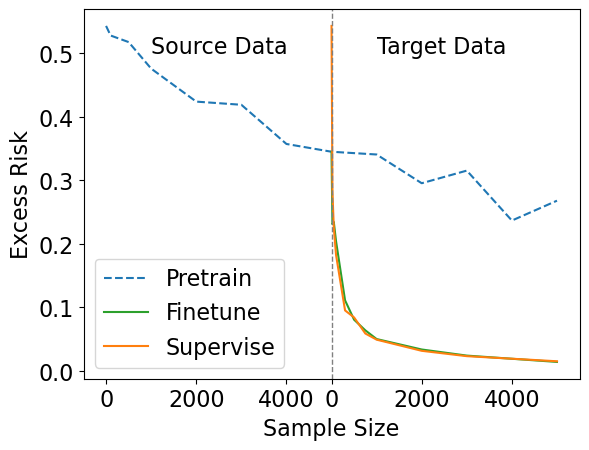

In [6]:
data = np.load('res1.npz')
loss_pretrain1,loss_supervise1,loss_finetune1  = data['x'], data['y'], data['z']

Ns_new = [i+5000 for i in Ns]
tmp = loss_pretrain1[7]
loss_pretrain1[7] = 0.5*tmp + 0.5*loss_finetune1[0] 
loss_finetune1[0]  = 0.5*tmp + 0.5*loss_finetune1[0] 

# fig, ax = plt.subplots(constrained_layout=True)
plt.plot(Ms,loss_pretrain1, "--",color = "tab:blue")
plt.plot(Ns_new,loss_finetune1, color = "tab:green")
plt.plot(Ns_new,loss_supervise1, color = "tab:orange")
# plt.plot(Ms[0:8], loss_pretrain3[0:8], "--", color = "tab:blue")

plt.xticks([0,  2000, 4000, 5000, 7000, 9000], 
           [0,  2000,  4000, 0,  2000,  4000], fontsize=16)
plt.yticks(fontsize=16)
plt.ylabel("Excess Risk", fontsize=16)
plt.xlabel("Sample Size", fontsize=16)

# secax = ax.secondary_xaxis('top')
# secax.set_xlabel('Source Sample Size (pretrain)', fontsize=14)
# ax.tick_params(fontsize=12)


plt.axvline(x = 5000, color = 'gray', linestyle = "--", linewidth=1)
plt.text(1000, 0.5, 'Source Data', fontsize = 16)
plt.text(6000, 0.5, 'Target Data', fontsize = 16)


# plt.xscale("log")
plt.legend(['Pretrain', 'Finetune', 'Supervise'], fontsize=16, loc=3)
plt.savefig('badcase_pretrain.pdf',  bbox_inches='tight')